# Assignment 3 – Maze Ball Player Modeling


Group members:
1. MUHAMMAD WAIZ WAFIQ BIN MOHAMAD JAFRI (17203410/2)
2. AIMAN SYAZWAN BIN ADAM (17201819/2)
3. MUHAMMAD TASNIMSYAMIM BIN ABDUL RAKI (17205733/2)
4. MUHAMMAD ZYAD ZARIN BIN ZAMBERI (17203070/2)
 

## Introduction

The Maze-Ball dataset provides valuable insights into player experiences during gameplay, encompassing various modalities such as gameplay attributes, physiological signals, and demographic information. This jupyter notebook aims to model affective states, specifically focusing on "Challenge" and "Anxiety," utilizing different supervised learning algorithms Gradient Boosters, Ensemble Learning and Support Vector Machine (SVM). The modalties used are demographic, physiological, gameplay, keystroke.

### The modalities:

1. Gameplay
2. Keystroke
3. Physiological
4. Demographic

### Feature Representation
To create a unified feature vector, we combined the following components for each entry:

1. Demographic information: player age, gender, playgames, playgamesfrequency
2. Gameplay information: score, time, distance to enemies, distance to pellets, tile visits
3. Keystroke information: counts of left, up, space, right, and down key presses
4. Physiological information: features extracted from skin conductance (SCR) and blood volume pulse (BVP)

## The Supervised Algorithms

### Gradient Boosters (HistGradientBoostingClassifier)
**Algorithm Type:** Gradient boosting is an ensemble learning technique that combines the predictions of several weak learners to create a strong learner.

**Specific Algorithm:** **HistGradientBoostingClassifier** is a variant of gradient boosting that is optimized for large datasets. It uses histogram-based techniques to speed up the training process.

**Usage in the Code:** The **HistGradientBoostingClassifier** is applied to the data using the **pred_model** function. It is used to predict the target variable based on the provided features.

Affective State is **"Anxiety"**

The modalities used:
1. Demographic
2. Physiological
3. Keystroke

### Ensemble Learning (Random Forest, Gradient Boosting, AdaBoost, Logistic Regression Stacking)
**Algorithm Type:** Ensemble learning combines multiple models to create a more robust and accurate model.

**Random Forest:** Random Forest is an ensemble of decision trees. It builds multiple trees and merges their predictions to improve accuracy and control overfitting.

**AdaBoost:** AdaBoost is an ensemble technique that assigns weights to data points and trains weak models sequentially. It gives more weight to misclassified points to improve performance.

**Logistic Regression Stacking:** Stacking involves training multiple models and combining their predictions using another model (meta-model). In this case, logistic regression is used as the meta-model to combine predictions from Random Forest, Gradient Boosting, and HistGradientBoostingClassifier.

**Usage in the Code:** The **pred_ensemble** function combines the predictions of RandomForestClassifier, GradientBoostingClassifier, and HistGradientBoostingClassifier using logistic regression as the meta-model.

Affective State is **"Anxiety"**
The modalities used:
1. Demographic
2. Physiological
3. Keystroke

### Support Vector Machine(SVM)

**Algorithm Type:** Support Vector Machine is a powerful supervised learning algorithm for classification and regression tasks. It works well in high-dimensional spaces and is effective in cases where the data is not linearly separable.

**Usage in the Code:** The **pred_model2** function applies a Support Vector Machine (SVC) using RandomizedSearchCV for hyperparameter tuning. It predicts the target variable based on the provided features.

Affective State is "Challenge"
The modalities used:
1. Demographic
2. Gameplay
3. Keystroke

###  Several strategies to improve the initial results, including:

1. **Feature Selection:** Used feature selection techniques to enhance the model's performance. For instance, in the SVM model **model_svm**, we examined the coefficients of the features after training the model and visualized them using a bar chart. This allowed us to identify the most influential features contributing to the model's predictions. By selecting features based on their coefficients, we focus on the most relevant information for the predictive task.

2. **Ensemble Learning:** Implemented ensemble learning, specifically stacking, to combine predictions from multiple models (Random Forest, Gradient Boosting, and HistGradientBoosting) in the **pred_ensemble** function. This ensemble method aimed to leverage the strengths of individual models and improve overall predictive performance.

3. **Normalization:** Before training the models, we applied normalization to the feature vectors using **QuantileTransformer()**. Normalizing the data can sometimes improve model convergence and performance, especially when features have different scales.


### Import the dependecies

In [54]:
# load Python packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt


from tqdm import tqdm
import xgboost
import shap

import warnings
warnings.filterwarnings("ignore")

# Gradient Boosters & Ensemble Learning

## Data Extraction

### Load the dataset

In [55]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [56]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [57]:
# let's take the first player as an example
player_no = 1
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(
    np.shape(p_games[player_no])))

Player information: 
{'player_id': 2, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 4}
Number of sets of games played by this player is (4,)


In [58]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [59]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


### Function to extract physiological and keystroke features

In [60]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
    ])

    feature_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
    ]

    return features_sc, feature_sc_names


def extract_bvp(signal):
    df, info = nk.ppg_process(
        p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    feature_bvp_names = list(feature_bvp)

    return feature_bvp.to_numpy()[0], feature_bvp_names


def extract_keystrokes(keystrokes_data):
    keys_of_interest = ['leftpressed', 'uppressed',
                        'spacepressed', 'rightpressed', 'downpressed']
    keystrokes_features = [sum(keystrokes_data[key])
                           for key in keys_of_interest]
    features_keystrokes_names = [f"{key}_count" for key in keys_of_interest]

    return keystrokes_features, features_keystrokes_names

### Extract the  demographic, keystroke and physiological features

In [61]:

alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
    #     'features_gameplay': [],
    'features_keystrokes': [],
    'features_sc': [],
    'features_bvp': [],

    'class': [],  # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
}

for a in tqdm(range(36)):  # player number
    player_demographics = p_demo[a]  # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)):  # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        # # Game A physiological features
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
        features_sc_a, features_sc_names = extract_sc(game_a['physio']['SC'])
        features_bvp_a, features_bvp_names = extract_bvp(
            game_a['physio']['BVP'])

        # Extract keystroke features
        features_keystrokes_a, features_keystrokes_names = extract_keystrokes(
            game_a['keystrokes'])

        # Game B physiological features
        features_sc_b, _ = extract_sc(game_b['physio']['SC'])
        features_bvp_b, _ = extract_bvp(game_b['physio']['BVP'])

        # Extract keystroke features
        features_keystrokes_b, _ = extract_keystrokes(game_b['keystrokes'])

        # which affective data to collect?
        c = "anxiety"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_a]
        alldata['features_bvp'] += [features_bvp_a]

        alldata['features_keystrokes'] += [features_keystrokes_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_sc'] += [features_sc_b]
        alldata['features_bvp'] += [features_bvp_b]

        alldata['features_keystrokes'] += [features_keystrokes_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A":  # if game A is more preferred than game B
            alldata['class'] += [1]  # class label for Game A
            alldata['class'] += [0]  # class label for Game B

        elif game_pref[c] == "B":  # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]

        # print(alldata['class'])

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:20<00:00,  1.72it/s]


### Create dataset

In [62]:
# create dataset
X = []  # training data (features)
Y = []  # class label   (target)
Z = []  # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                  alldata['player_gender'][i],
                  alldata['player_playgames'][i],
                  alldata['player_playfrequency'][i],
                  alldata['game_variant'][i]
                  ]),
        alldata['features_sc'][i],
        alldata['features_bvp'][i],
        alldata['features_keystrokes'][i],
    ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_sc_names
feature_names += features_bvp_names
feature_names += features_keystrokes_names

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

### Data Cleaning

In [63]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.DataFrame(data=X, columns=feature_names)
df[c] = Y
print(df.shape)
df.head()

(288, 100)


,player_age,player_gender,player_playgames,player_playfrequency,game_variant,SCR_Amplitude_mean,SCR_Amplitude_std,SCR_RiseTime_mean,SCR_RiseTime_std,SCR_RecoveryTime_mean,SCR_RecoveryTime_std,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,leftpressed_count,uppressed_count,spacepressed_count,rightpressed_count,downpressed_count,anxiety
0,26.0,1.0,1.0,5.0,1.0,0.358530,0.312950,0.859583,0.406223,0.491935,0.360205,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,21.0,0.0,0.0,27.0,18.0,0
1,26.0,1.0,1.0,5.0,1.0,0.665741,0.404745,1.136364,0.427391,0.697389,0.343626,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,26.0,1.0,0.0,21.0,16.0,1
2,26.0,1.0,1.0,5.0,8.0,0.918398,0.823357,1.479263,0.760327,1.142857,0.994538,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,17.0,6.0,5.0,17.0,14.0,1
3,26.0,1.0,1.0,5.0,8.0,0.448668,0.665879,1.115207,0.649034,1.396313,0.858801,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.00258

In [64]:
# Check for columns with missing vals
missing_vals_cols = df.isna().sum()
missing_vals_cols[missing_vals_cols > 0]

SCR_Amplitude_mean         1
SCR_Amplitude_std          1
SCR_RiseTime_mean          1
SCR_RiseTime_std           1
SCR_RecoveryTime_mean      1
SCR_RecoveryTime_std       1
HRV_SDANN1               288
HRV_SDNNI1               288
HRV_SDANN2               288
HRV_SDNNI2               288
HRV_SDANN5               288
HRV_SDNNI5               288
HRV_ULF                  288
HRV_VLF                  288
dtype: int64

In [65]:
# Check the row with missing values on the column that has 1 missing val
df[df['SCR_Amplitude_mean'].isna()]

,player_age,player_gender,player_playgames,player_playfrequency,game_variant,SCR_Amplitude_mean,SCR_Amplitude_std,SCR_RiseTime_mean,SCR_RiseTime_std,SCR_RecoveryTime_mean,SCR_RecoveryTime_std,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_ULF,HRV_VLF,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,leftpressed_count,uppressed_count,spacepressed_count,rightpressed_count,downpressed_count,anxiety
72,29.0,1.0,1.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,61.229719,980.645161,58.589707,NaN,NaN,NaN,NaN,NaN,NaN,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,NaN,NaN,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,28.0,0.0,0.0,29.0,7.0,0


In [66]:
# Fill up the missing values on row 72
cols_2_fill = ['SCR_Amplitude_mean', 'SCR_Amplitude_std', 'SCR_RiseTime_mean', 'SCR_RiseTime_std', 'SCR_RecoveryTime_mean', 'SCR_RecoveryTime_std']
df.loc[72, cols_2_fill] = df.mean()
print("Values filled: ")
df.loc[72, cols_2_fill]

Values filled: 


SCR_Amplitude_mean       0.370727
SCR_Amplitude_std        0.305722
SCR_RiseTime_mean        1.183024
SCR_RiseTime_std         0.720504
SCR_RecoveryTime_mean    1.242509
SCR_RecoveryTime_std     1.091095
Name: 72, dtype: float64

In [67]:
# Drop the columns with missing vals in all rows
try:
    df.drop(columns=[
            'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
            'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5',
            'HRV_ULF', 'HRV_VLF'
            ], inplace=True)
except KeyError:
    print("Columns Dropped!")

In [68]:
print(f"Dim: {df.shape}")
df.head()

Dim: (288, 92)


,player_age,player_gender,player_playgames,player_playfrequency,game_variant,SCR_Amplitude_mean,SCR_Amplitude_std,SCR_RiseTime_mean,SCR_RiseTime_std,SCR_RecoveryTime_mean,SCR_RecoveryTime_std,PPG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_SDSD,HRV_CVNN,HRV_CVSD,HRV_MedianNN,HRV_MadNN,HRV_MCVNN,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,HRV_LF,HRV_HF,HRV_VHF,HRV_TP,HRV_LFHF,HRV_LFn,HRV_HFn,HRV_LnHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,HRV_PAS,HRV_GI,HRV_SI,HRV_AI,HRV_PI,HRV_C1d,HRV_C1a,HRV_SD1d,HRV_SD1a,HRV_C2d,HRV_C2a,HRV_SD2d,HRV_SD2a,HRV_Cd,HRV_Ca,HRV_SDNNd,HRV_SDNNa,HRV_DFA_alpha1,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,HRV_ApEn,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,leftpressed_count,uppressed_count,spacepressed_count,rightpressed_count,downpressed_count,anxiety
0,26.0,1.0,1.0,5.0,1.0,0.358530,0.312950,0.859583,0.406223,0.491935,0.360205,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,21.0,0.0,0.0,27.0,18.0,0
1,26.0,1.0,1.0,5.0,1.0,0.665741,0.404745,1.136364,0.427391,0.697389,0.343626,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,26.0,1.0,0.0,21.0,16.0,1
2,26.0,1.0,1.0,5.0,8.0,0.918398,0.823357,1.479263,0.760327,1.142857,0.994538,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065613,37.27485,0.532394,0.467606,47.552092,44.564884,0.513441,0.486559,42.20148,41.081889,0.520401,0.795305,0.607206,0.893675,-0.140908,-1.092152,-0.1398,0.000308,0.048143,0.767695,1.731656,2.774938,1.583665,1.277666,1.253381,1.651794,0.842629,2.009294,4.415038,0.577054,17.0,6.0,5.0,17.0,14.0,1
3,26.0,1.0,1.0,5.0,8.0,0.448668,0.665879,1.115207,0.649034,1.396313,0.858801,61.229719,980.645161,58.589707,72.937186,73.349525,0.059746,0.074377,1000.0,47.825806,0.047826,96.774194,0.80329,935.483871,1032.258065,48.888889,83.333333,838.709677,1096.774194,3.6,164.0625,0.011161,0.048783,0.002586,0.062531,0.228797,0.178496,0.780148,-3.020368,51.865947,65.170778,0.795847,10619.035879,1.256523,4.733055,327.554445,0.755556,0.76,1.0,0.285714,49.689441,49.696817,49.683931,46.666667,0.483516,0.516484,36.065

### Save the dataset

In [69]:
df.to_csv('cleaned_model1.csv', index=False)

In [70]:
X_cleaned = df.iloc[:, :-1].values
feature_names_cleaned = df.iloc[:, :-1].columns
Y_cleaned = df.iloc[:, -1].values

X_cleaned.shape, Y_cleaned.shape

((288, 91), (288,))

### Before normalization

<Axes: >

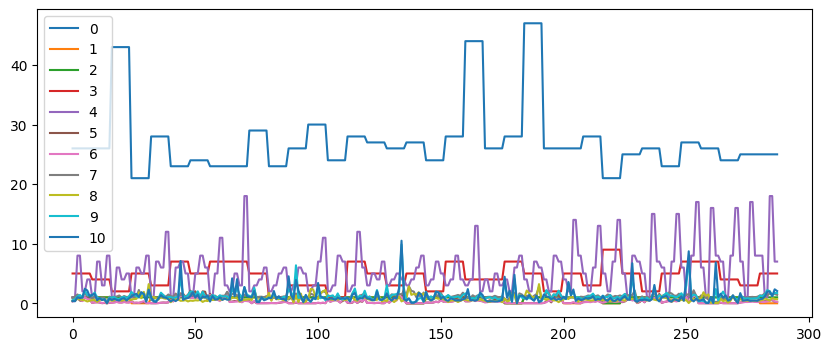

In [71]:
# Before normalization
pd.DataFrame(X_cleaned).iloc[:1000, :11].plot(figsize=(10, 4))

### After Normalization

<Axes: >

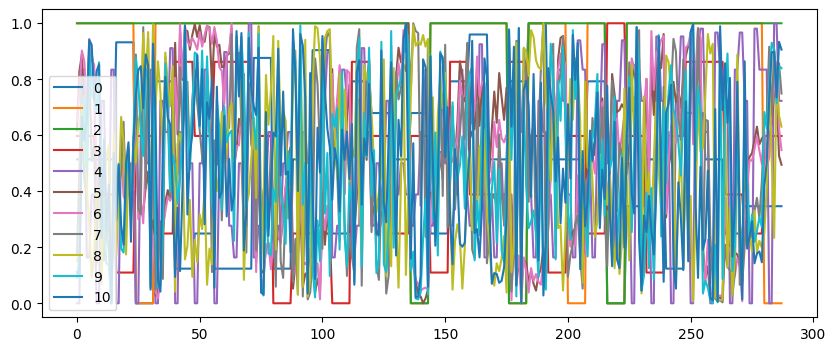

In [72]:
# After Normalization
X_cleaned_norm = QuantileTransformer().fit_transform(X_cleaned)
pd.DataFrame(X_cleaned_norm).iloc[:1000, :11].plot(figsize=(10, 4))

## Model Training (Gradient Boosting)

In [73]:
def pred_model(X, Y, Z):
    predictions_histgb = []
    labels_histgb = []

    # Perform leave-one-person-out cross-validation
    for idx in player_id:
        istrain = Z != idx
        istest = Z == idx

        X_train = X[istrain]
        X_test = X[istest]
        Y_train = Y[istrain]
        Y_test = Y[istest]

        model_histgb = HistGradientBoostingClassifier(
            random_state=123)  
        model_histgb.fit(X_train, Y_train)

        Y_predicted_histgb = model_histgb.predict(X_test)

        predictions_histgb += [Y_predicted_histgb]
        labels_histgb += [Y_test]

    accuracy_histgb = accuracy_score(np.concatenate(
        labels_histgb), np.concatenate(predictions_histgb))
    print("HistGradientBoostingClassifier Accuracy:", accuracy_histgb)
    return model_histgb

## Result 

### Accuracy

In [74]:
model1 = pred_model(X_cleaned_norm, Y_cleaned, Z)

HistGradientBoostingClassifier Accuracy: 0.4722222222222222


### Feature Importance Analysis with SHAP

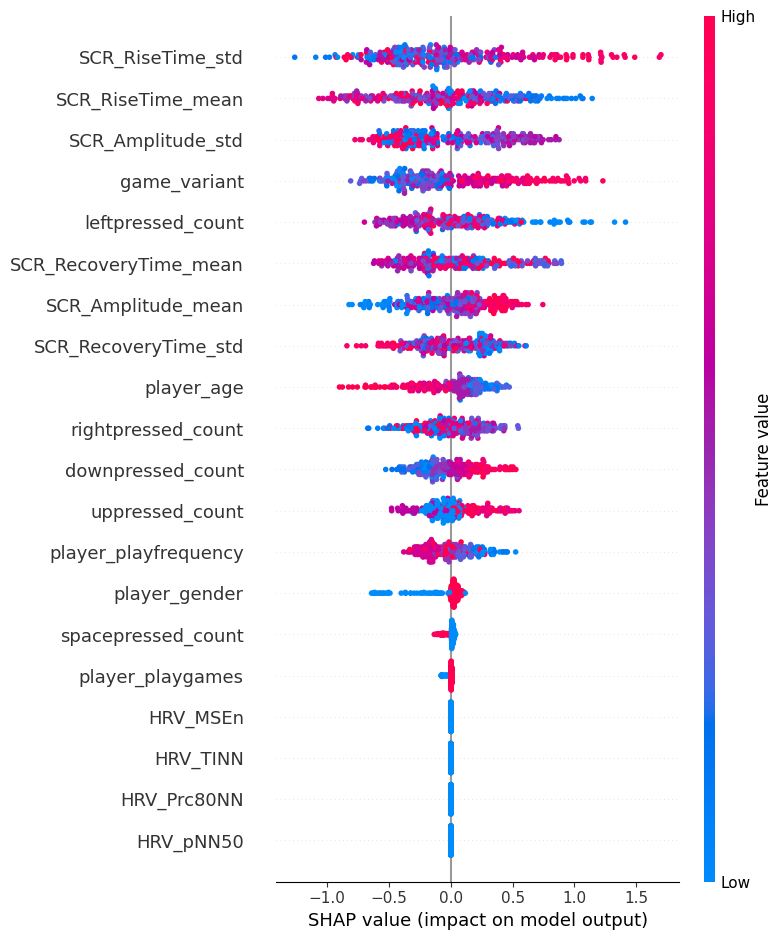

In [75]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_cleaned_norm)
shap.summary_plot(shap_values, X_cleaned_norm, feature_names=feature_names_cleaned)

In [76]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

feature_importance = pd.DataFrame({'Feature': feature_names_cleaned, 'MeanAbsShap': mean_abs_shap_values})

f_imp_df = feature_importance.sort_values(by='MeanAbsShap', ascending=False)

# The features with SHAP value > 0.05 are selected
features_selected = list(f_imp_df[f_imp_df['MeanAbsShap'] > 0.05]['Feature'])
features_selected

['SCR_RiseTime_std',
 'SCR_RiseTime_mean',
 'SCR_Amplitude_std',
 'game_variant',
 'leftpressed_count',
 'SCR_RecoveryTime_mean',
 'SCR_Amplitude_mean',
 'SCR_RecoveryTime_std',
 'player_age',
 'rightpressed_count',
 'downpressed_count',
 'uppressed_count',
 'player_playfrequency',
 'player_gender']

In [77]:
X_cleaned = df[features_selected].values
# X_cleaned = df.iloc[:, :-1].values
Y_cleaned = df.iloc[:, -1].values

In [78]:
X_cleaned.shape, Y_cleaned.shape

((288, 14), (288,))

### Before Normalization

<Axes: >

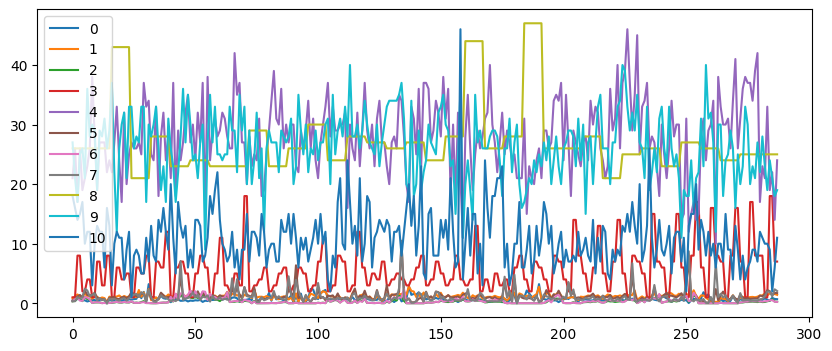

In [79]:
# Before normalization
pd.DataFrame(X_cleaned).iloc[:1000, :11].plot(figsize=(10, 4))

### After Normalization

<Axes: >

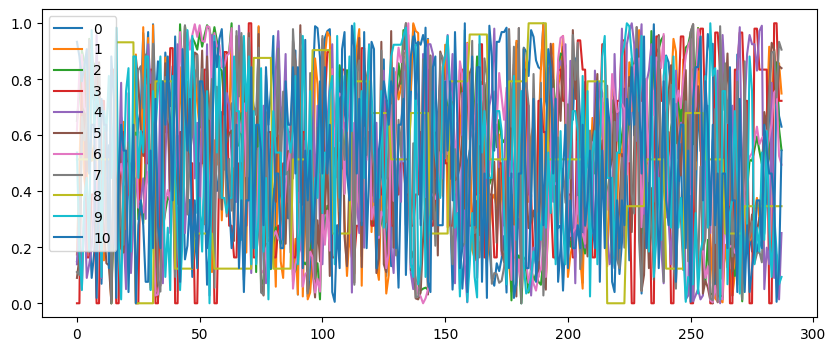

In [80]:
# After Normalization
X_cleaned_norm = QuantileTransformer().fit_transform(X_cleaned)
pd.DataFrame(X_cleaned_norm).iloc[:1000, :11].plot(figsize=(10, 4))

In [81]:
model2 = pred_model(X_cleaned_norm, Y_cleaned, Z)

HistGradientBoostingClassifier Accuracy: 0.5104166666666666


### Feature Importance Analysis with SHAP

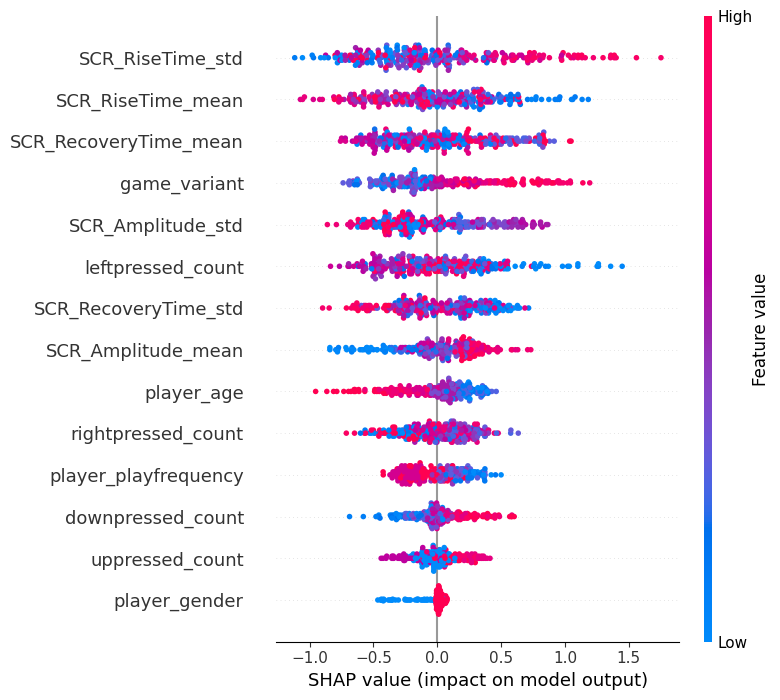

In [82]:
# Create a SHAP explainer for the trained model
explainer = shap.TreeExplainer(model2)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X_cleaned_norm)

# Display the summary plot
# Provide feature names if available
shap.summary_plot(shap_values, X_cleaned_norm, feature_names=features_selected)

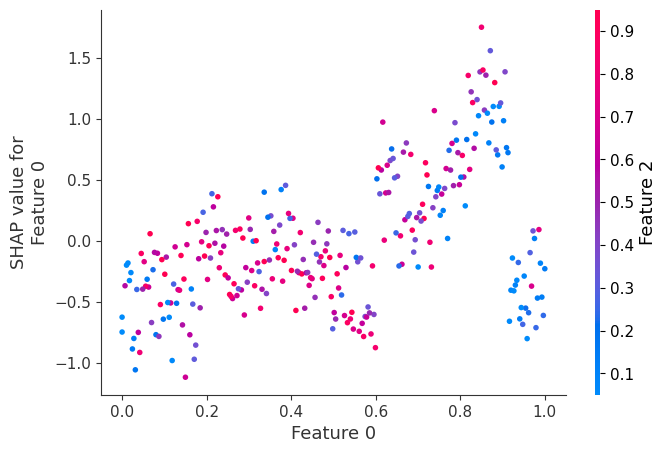

In [83]:
shap.dependence_plot(0, shap_values, X_cleaned_norm)

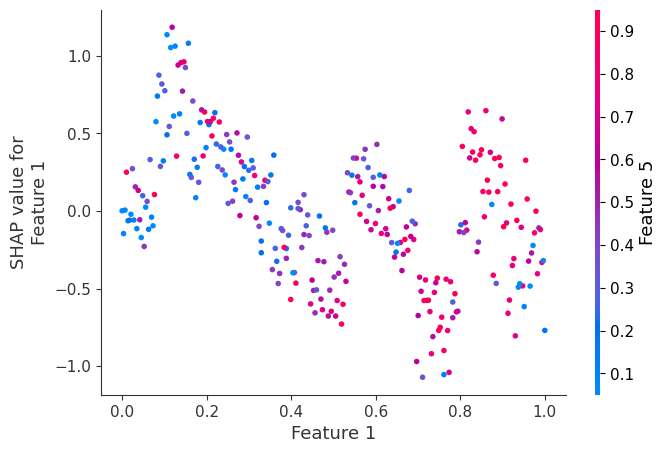

In [84]:
shap.dependence_plot(1, shap_values, X_cleaned_norm)

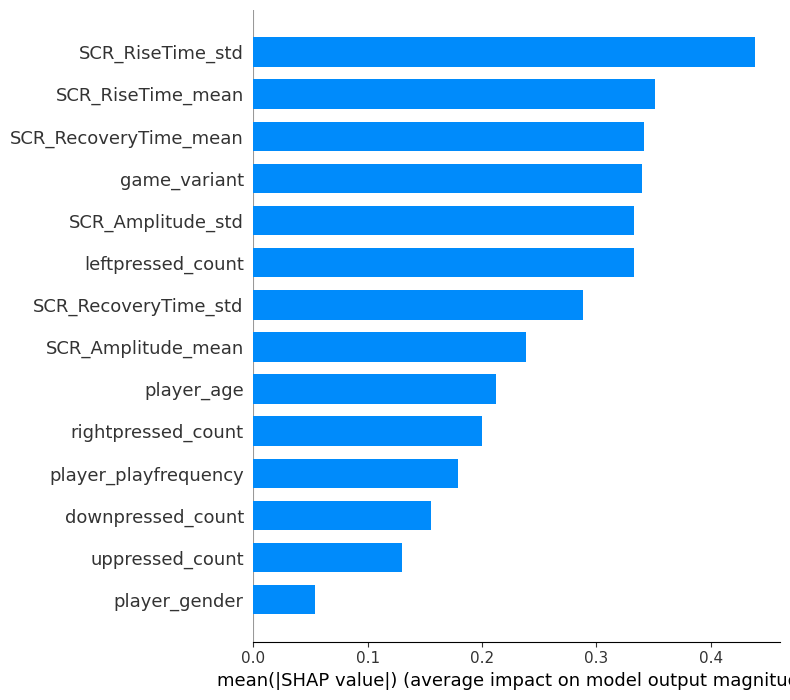

In [85]:
shap.summary_plot(shap_values, X_cleaned_norm, plot_type="bar", feature_names=features_selected)

## Model Training (Ensemble Learning)

In [86]:
def pred_ensemble(X, Y, seed):
    # RandomForestClassifier
    best_rf_model = RandomForestClassifier(random_state=seed)
    best_rf_model.fit(X, Y)
    print(f"RandomForestClassifier trained successfully!")

    # GradientBoostingClassifier
    best_gb_model = GradientBoostingClassifier(random_state=seed)
    best_gb_model.fit(X, Y)
    print(f"GradientBoostingClassifier trained successfully!")

    # HistGradientBoostingClassifier
    best_hist_gb_model = HistGradientBoostingClassifier(
        random_state=seed)
    best_hist_gb_model.fit(X, Y)
    print(f"HistGradientBoostingClassifier trained successfully!")

    # DecisionTreeClassifier
    best_dt_model = DecisionTreeClassifier(random_state=seed)
    best_dt_model.fit(X, Y)
    print(f"DecisionTreeClassifier trained successfully!")

    # AdaBoostClassifier
    best_adaboost_model = AdaBoostClassifier(random_state=seed)
    best_adaboost_model.fit(X, Y)
    print(f"AdaBoostClassifier trained successfully!")

    # Stack the models
    predictions = []
    for model, model_name in [
        (best_rf_model, 'RandomForestClassifier'),
        (best_gb_model, 'GradientBoostingClassifier'),
        (best_hist_gb_model, 'HistGradientBoostingClassifier'),
        # (best_dt_model, 'DecisionTreeClassifier'),
        # (best_adaboost_model, 'AdaBoostClassifier'),
    ]:
        print(f"Predicting for {model_name}...", end=' ')
        p = cross_val_predict(model, X, Y, cv=LeaveOneOut())
        predictions.append(p)
        print(f"Completed!")

    stacked_X = np.column_stack(predictions)

    meta_model = LogisticRegression(random_state=seed)
    meta_model.fit(stacked_X, Y)
    print(f"LogisticRegression trained successfully!")

    stacked_predictions = cross_val_predict(
        meta_model, stacked_X, Y, cv=LeaveOneOut())

    accuracy_stacked = accuracy_score(Y, stacked_predictions)
    print("Ensemble (Stacking) Accuracy:", accuracy_stacked)

    return meta_model, best_rf_model, best_gb_model, best_hist_gb_model

## Result

### Accuracy

In [87]:
model_ensemble = pred_ensemble(X_cleaned_norm, Y_cleaned, seed=123)

RandomForestClassifier trained successfully!
GradientBoostingClassifier trained successfully!
HistGradientBoostingClassifier trained successfully!
DecisionTreeClassifier trained successfully!
AdaBoostClassifier trained successfully!
Predicting for RandomForestClassifier... Completed!
Predicting for GradientBoostingClassifier... Completed!
Predicting for HistGradientBoostingClassifier... Completed!
LogisticRegression trained successfully!
Ensemble (Stacking) Accuracy: 0.5243055555555556


# Support Vector Machine (SVM)

## Data Extraction

### Load the dataset

In [88]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [89]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [90]:
# let's take the first player as an example
player_no = 1
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(
    np.shape(p_games[player_no])))

Player information: 
{'player_id': 2, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 4}
Number of sets of games played by this player is (4,)


In [91]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [92]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


### Functions to extract gameplay and keystroke features 

In [93]:
def extract_gameplay_features(gameplay_data):
    # Extract relevant features from gameplay data
    score = gameplay_data['score']
    time = gameplay_data['time']
    distance_to_enemies_euclidean = gameplay_data['distance2enemies_euclidean']
    distance_to_pellets_euclidean = gameplay_data['distance2pellets_euclidean']
    tile_visits = gameplay_data['tilevisits']
    # Assuming 'event' is a relevant feature for challenge
    events = gameplay_data['event']

    # Concatenate all features into a single feature vector
    feature_vector = [score, time, distance_to_enemies_euclidean,
                      distance_to_pellets_euclidean, tile_visits]

    # Define the names of the features
    feature_names = [
        'score',
        'time',
        'distance_to_enemies_euclidean',
        'distance_to_pellets_euclidean',
        'tile_visits'
    ]

    return feature_vector, feature_names


def extract_keystrokes(keystrokes_data):
    keys_of_interest = ['leftpressed', 'uppressed',
                        'spacepressed', 'rightpressed', 'downpressed']
    keystrokes_features = [sum(keystrokes_data[key])
                           for key in keys_of_interest]
    features_keystrokes_names = [f"{key}_count" for key in keys_of_interest]

    return keystrokes_features, features_keystrokes_names

### Extract the demographic, gameplay and keystroke features

In [94]:

alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
    'features_gameplay': [],
    'features_keystrokes': [],

    'class': [],  # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
}

for a in tqdm(range(36)):  # player number
    player_demographics = p_demo[a]  # player demographics
    player_game = p_games[a]
    player_tutorial = p_tutorial[a]

    for b in range(len(player_game)):  # game number
        game_pref = p_games[a][b]['preferences']
        game_a = p_games[a][b]['data']['A'][0]
        game_b = p_games[a][b]['data']['B']

        # # Game A gameplay features
        # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

        # # Game A keystroke features
        # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

        #
        # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?

        # Game A gameplay features
        features_gameplay_a, features_gameplay_names = extract_gameplay_features(
            game_a['gameplay'])

        # Extract keystroke features
        features_keystrokes_a, features_keystrokes_names = extract_keystrokes(
            game_a['keystrokes'])

        # Game B gameplay features
        features_gameplay_b, _ = extract_gameplay_features(game_b['gameplay'])

        # Extract keystroke features
        features_keystrokes_b, _ = extract_keystrokes(game_b['keystrokes'])

        # which affective data to collect?
        c = "challenge"

        # append information for Game A
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_gameplay'] += [features_keystrokes_a]
        alldata['features_keystrokes'] += [features_keystrokes_a]

        # append information for Game B
        alldata['player_id'] += [player_demographics['player_id']]
        alldata['player_age'] += [player_demographics['age']]
        alldata['player_gender'] += [player_demographics['male']]
        alldata['player_playgames'] += [player_demographics['playgames']]
        alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

        alldata['game_variant'] += [game_a['variant']]
        alldata['features_gameplay'] += [features_keystrokes_b]
        alldata['features_keystrokes'] += [features_keystrokes_b]

        # generate labels based on preference ranking
        if game_pref[c] == "A":  # if game A is more preferred than game B
            alldata['class'] += [1]  # class label for Game A
            alldata['class'] += [0]  # class label for Game B

        elif game_pref[c] == "B":  # if game B is more preferred
            alldata['class'] += [0]
            alldata['class'] += [1]

        elif game_pref[c] == "Both equally":
            alldata['class'] += [1]
            alldata['class'] += [1]

        elif game_pref[c] == "Neither":
            alldata['class'] += [0]
            alldata['class'] += [0]

        # print(alldata['class'])

100%|██████████| 36/36 [00:00<00:00, 5056.93it/s]


### Create dataset

In [95]:

# create dataset
X = []  # training data
Y = []  # class label
Z = []  # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                  alldata['player_gender'][i],
                  alldata['player_playgames'][i],
                  alldata['player_playfrequency'][i],
                  alldata['game_variant'][i]
                  ]),
        alldata['features_gameplay'][i],
        alldata['features_keystrokes'][i],
    ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_gameplay_names
feature_names += features_keystrokes_names

X = np.array(X)
# X = np.nan_to_num(X, nan=np.nanmean(X))
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

### Data Cleaning


In [96]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df = pd.DataFrame(data=X, columns=feature_names)
df[c] = Y
print(df.shape)
df.head()

(288, 16)


,player_age,player_gender,player_playgames,player_playfrequency,game_variant,score,time,distance_to_enemies_euclidean,distance_to_pellets_euclidean,tile_visits,leftpressed_count,uppressed_count,spacepressed_count,rightpressed_count,downpressed_count,challenge
0,26.0,1.0,1.0,5.0,1.0,21.0,0.0,0.0,27.0,18.0,21.0,0.0,0.0,27.0,18.0,0
1,26.0,1.0,1.0,5.0,1.0,26.0,1.0,0.0,21.0,16.0,26.0,1.0,0.0,21.0,16.0,1
2,26.0,1.0,1.0,5.0,8.0,17.0,6.0,5.0,17.0,14.0,17.0,6.0,5.0,17.0,14.0,0
3,26.0,1.0,1.0,5.0,8.0,26.0,2.0,0.0,25.0,15.0,26.0,2.0,0.0,25.0,15.0,1
4,26.0,1.0,1.0,5.0,2.0,19.0,1.0,0.0,26.0,17.0,19.0,1.0,0.0,26.0,17.0,1


In [97]:
# Check for columns with missing vals
missing_vals_cols = df.isna().sum()
missing_vals_cols[missing_vals_cols > 0]

Series([], dtype: int64)

In [98]:
df.to_csv('cleaned_model2.csv', index=False)

In [99]:
X_cleaned = df.iloc[:, :-1].values
feature_names_cleaned = df.iloc[:, :-1].columns
Y_cleaned = df.iloc[:, -1].values

X_cleaned.shape, Y_cleaned.shape

((288, 15), (288,))

### Before normalization

<Axes: >

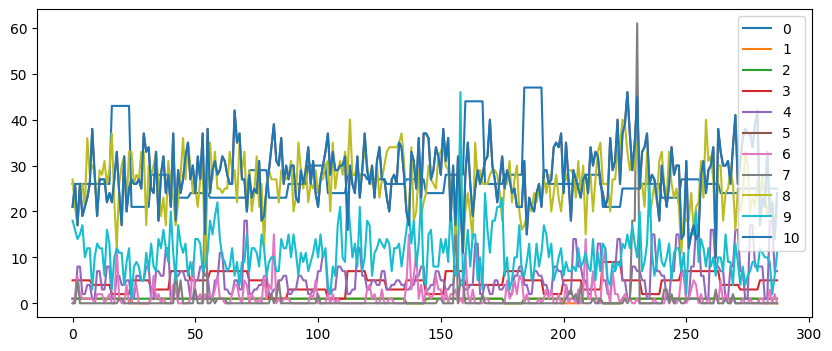

In [100]:
# Before normalization
pd.DataFrame(X_cleaned).iloc[:1000, :11].plot(figsize=(10, 4))

### After Normalization

<Axes: >

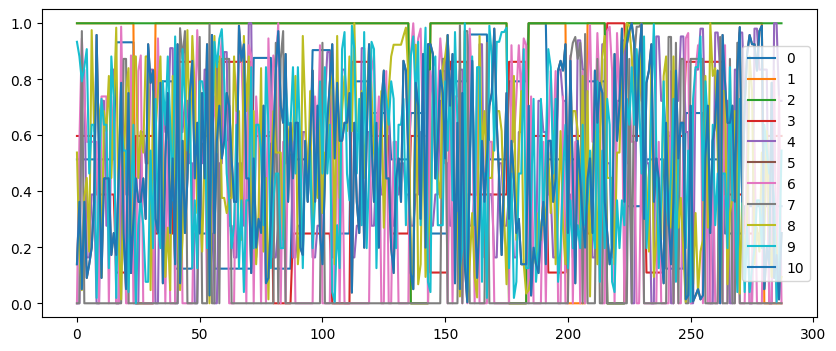

In [101]:
# After Normalization
X_cleaned_norm = QuantileTransformer().fit_transform(X_cleaned)
pd.DataFrame(X_cleaned_norm).iloc[:1000, :11].plot(figsize=(10, 4))

## Model Training (SVM)

In [102]:
def pred_model2(X, Y, Z):
    predictions_svm = []
    labels_svm = []

    param_distributions = {
        'C': [0.1, 0.5, 1],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 1.0],
        'decision_function_shape': ['ovo', 'ovr']
    }

    for idx in player_id:
        istrain, istest = Z != idx, Z == idx
        X_train, X_test = X[istrain], X[istest]
        Y_train, Y_test = Y[istrain], Y[istest]

        random_search_svm = RandomizedSearchCV(
            SVC(), param_distributions, n_iter=10, cv=LeaveOneOut(), scoring='accuracy', n_jobs=-1)
        random_search_svm.fit(X_train, Y_train)

        best_model_svm = random_search_svm.best_estimator_
        print(f"Best parameters: {random_search_svm.best_params_}")

        Y_predicted_svm = best_model_svm.predict(X_test)

        predictions_svm.append(Y_predicted_svm)
        labels_svm.append(Y_test)

    accuracy_svm = accuracy_score(np.concatenate(
        labels_svm), np.concatenate(predictions_svm))
    print("SVM Accuracy:", accuracy_svm)

    return best_model_svm

In [107]:
model_svm = pred_model2(X_cleaned_norm, Y_cleaned, Z)

Best parameters: {'kernel': 'linear', 'gamma': 'auto', 'decision_function_shape': 'ovo', 'C': 0.1}
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'decision_function_shape': 'ovo', 'C': 0.5}
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'decision_function_shape': 'ovo', 'C': 0.5}
Best parameters: {'kernel': 'linear', 'gamma': 'scale', 'decision_function_shape': 'ovo', 'C': 0.5}
Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 1}
Best parameters: {'kernel': 'linear', 'gamma': 0.1, 'decision_function_shape': 'ovo', 'C': 0.1}
Best parameters: {'kernel': 'rbf', 'gamma': 0.1, 'decision_function_shape': 'ovo', 'C': 1}
Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'decision_function_shape': 'ovr', 'C': 1}
Best parameters: {'kernel': 'linear', 'gamma': 1.0, 'decision_function_shape': 'ovr', 'C': 0.1}
Best parameters: {'kernel': 'linear', 'gamma': 0.1, 'decision_function_shape': 'ovr', 'C': 0.5}
Best parameters: {'kernel': 'linea

### Feature Importance Analysis for SVM

In [108]:
# Positive coefficients indicate a positive contribution to the prediction,
# while negative coefficients indicate a negative contribution.
coefficients = model_svm.coef_.flatten()
print(coefficients)

[-2.14978759e-04  1.33801322e-04 -2.85759069e-04  1.64968969e-04
  3.82901888e-04  2.19047101e-04  1.01455941e-04 -1.02851830e+00
 -9.04380324e-06  2.17937127e-04  2.19047101e-04  1.01455941e-04
 -1.02851830e+00 -9.04380324e-06  2.17937127e-04]


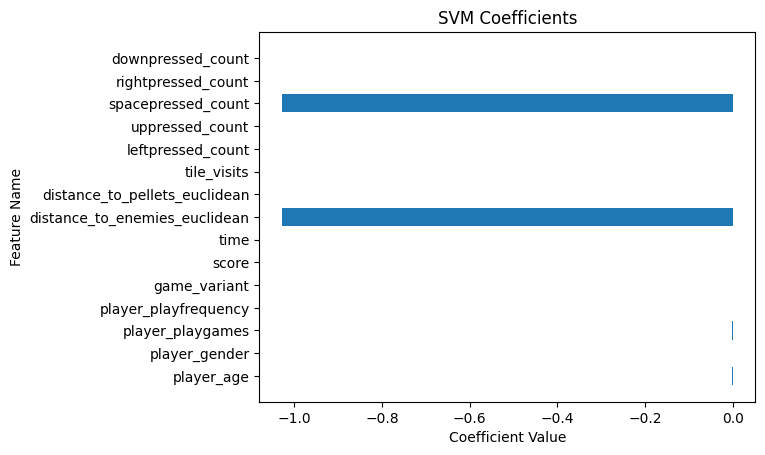

In [109]:
# Get the coefficients and feature names
coefficients = model_svm.coef_.flatten()

# Plot the coefficients
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('SVM Coefficients')
plt.show()

###  Several strategies to improve the initial results, including:

1. **Feature Selection:** Used feature selection techniques to enhance the model's performance. For instance, in the SVM model **model_svm**, we examined the coefficients of the features after training the model and visualized them using a bar chart. This allowed us to identify the most influential features contributing to the model's predictions. By selecting features based on their coefficients, we focus on the most relevant information for the predictive task.

2. **Ensemble Learning:** Implemented ensemble learning, specifically stacking, to combine predictions from multiple models (Random Forest, Gradient Boosting, and HistGradientBoosting) in the **pred_ensemble** function. This ensemble method aimed to leverage the strengths of individual models and improve overall predictive performance.

3. **Normalization:** Before training the models, we applied normalization to the feature vectors using **QuantileTransformer()**. Normalizing the data can sometimes improve model convergence and performance, especially when features have different scales.
